In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split

import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Brain_Tumor_Detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/content/drive/MyDrive/Brain_Tumor_Detection/yes/y438.jpg
/content/drive/MyDrive/Brain_Tumor_Detection/pred/pred20.jpg
/content/drive/MyDrive/Brain_Tumor_Detection/no/no1429.jpg


In [ ]:
folder_path_no = "/content/drive/MyDrive/Brain_Tumor_Detection/no"
folder_path_yes = "/content/drive/MyDrive/Brain_Tumor_Detection/yes"

folder_no = os.listdir(folder_path_no)
folder_yes = os.listdir(folder_path_yes)

print(len(folder_no))
print(len(folder_yes))

1500
1500


In [ ]:
no_label = [0]*len(folder_no)
yes_label = [1]*len(folder_yes)
labels = no_label + yes_label
print(len(labels))

3000


In [ ]:
data = []

for img in folder_no:
    image = Image.open("/content/drive/MyDrive/Brain_Tumor_Detection/no/"+img)
    image = image.resize((224,224))
    image = image.convert("RGB")
    image = np.array(image)
    data.append(image)

for img in folder_yes:
    image = Image.open("/content/drive/MyDrive/Brain_Tumor_Detection/yes/"+img)
    image = image.resize((224,224))
    image = image.convert("RGB")
    image = np.array(image)
    data.append(image)

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Define paths to your image folders
path_no = "/content/drive/MyDrive/Brain_Tumor_Detection/no/"
path_yes = "/content/drive/MyDrive/Brain_Tumor_Detection/yes/"

# Define image dimensions
img_width, img_height = 224, 224

# Use ImageDataGenerator for efficient loading and augmentation
datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess images using the generators
data_no = np.array([img_to_array(load_img(path_no + img, target_size=(img_width, img_height))) for img in os.listdir(path_no)])
data_yes = np.array([img_to_array(load_img(path_yes + img, target_size=(img_width, img_height))) for img in os.listdir(path_yes)])

# Optionally, you can add labels (0 for 'no' class and 1 for 'yes' class)
labels_no = np.zeros(len(data_no))
labels_yes = np.ones(len(data_yes))

# Concatenate the data and labels
data = np.concatenate([data_no, data_yes])
labels = np.concatenate([labels_no, labels_yes])

# Shuffle the data and labels together
data, labels = shuffle(data, labels, random_state=42)

In [ ]:
x = np.array(data)
y = np.array(labels)


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 224, 224, 3)
(600, 224, 224, 3)
(2400,)
(600,)


In [ ]:
x_train_normalized = x_train / 255.0
print("train data shape:", x_train_normalized.shape)

train data shape: (2400, 224, 224, 3)


In [ ]:
x_test_normalized = x_test / 255.0
print("train data shape:", x_test_normalized.shape)

train data shape: (600, 224, 224, 3)


early stoping

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create pre-trained Xception model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers of the Xception base model
for layer in xception_model.layers:
    layer.trainable = False

# Build a new model on top of Xception
model = Sequential([
    xception_model,
    GlobalAveragePooling2D(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train_normalized, y_train,
    epochs=50, validation_data=(x_test_normalized, y_test),
    callbacks=[early_stopping]
)

# Print final loss and accuracy
final_loss, final_acc = model.evaluate(x_test_normalized, y_test)
print("Final Loss on Test Data:", final_loss)
print("Accuracy on Test Data:", final_acc)

# Print learning rate
print("Learning Rate:", model.optimizer.learning_rate.numpy())

# Print the number of Dense layers
dense_layer_count = sum([1 for layer in model.layers if isinstance(layer, Dense)])
print("Number of Dense Layers:", dense_layer_count)
model.summary()


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

with drop out and early stopping

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create pre-trained Xception model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers of the Xception base model
for layer in xception_model.layers:
    layer.trainable = False

    early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Build a new model on top of Xception
model = Sequential([
    xception_model,
    GlobalAveragePooling2D(),
    Dense(4096, activation='relu'),
    Dropout(0.5),  # Add Dropout with a dropout rate of 0.5
    Dense(4096, activation='relu'),
    Dropout(0.5),  # Add another Dropout layer
    Dense(1, activation='sigmoid')
])

# Modify the learning rate in the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train_normalized, y_train,
    epochs=50, validation_data=(x_test_normalized, y_test),
    callbacks=[early_stopping]
)

# Print final loss and accuracy
final_loss, final_acc = model.evaluate(x_test_normalized, y_test)
print("Final Loss on Test Data:", final_loss)
print("Accuracy on Test Data:", final_acc)

# Print learning rate
print("Learning Rate:", model.optimizer.learning_rate.numpy())

# Print the number of Dense layers
dense_layer_count = sum([1 for layer in model.layers if isinstance(layer, Dense)])
print("Number of Dense Layers:", dense_layer_count)


Epoch 1/50
75/75 [==============================] - 28s 232ms/step - loss: 0.5725 - accuracy: 0.7371 - val_loss: 0.4294 - val_accuracy: 0.8567
Epoch 2/50
75/75 [==============================] - 13s 168ms/step - loss: 0.4023 - accuracy: 0.8558 - val_loss: 0.3183 - val_accuracy: 0.8850
Epoch 3/50
75/75 [==============================] - 13s 167ms/step - loss: 0.3095 - accuracy: 0.8929 - val_loss: 0.2574 - val_accuracy: 0.9117
Epoch 4/50
75/75 [==============================] - 13s 171ms/step - loss: 0.2576 - accuracy: 0.9100 - val_loss: 0.2209 - val_accuracy: 0.9233
Epoch 5/50
75/75 [==============================] - 13s 175ms/step - loss: 0.2186 - accuracy: 0.9267 - val_loss: 0.2009 - val_accuracy: 0.9250
Epoch 6/50
75/75 [==============================] - 13s 178ms/step - loss: 0.1984 - accuracy: 0.9329 - val_loss: 0.1866 - val_accuracy: 0.9367
Epoch 7/50
75/75 [==============================] - 13s 178ms/step - loss: 0.1775 - accuracy: 0.9388 - val_loss: 0.1729 - val_accuracy: 0.9400

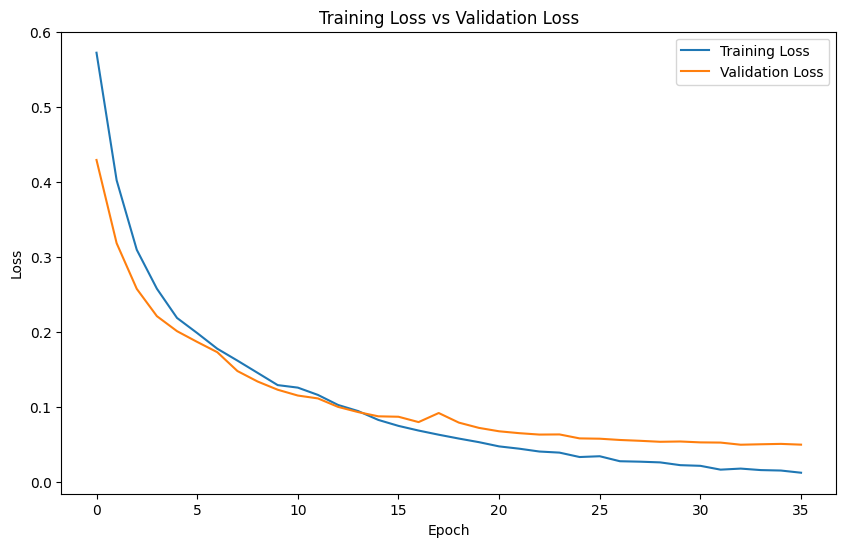

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1 Relu , 1 Tanh and sigmoid

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create pre-trained Xception model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers of the Xception base model
for layer in xception_model.layers:
    layer.trainable = False

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Build a new model on top of Xception
model = Sequential([
    xception_model,
    GlobalAveragePooling2D(),
    Dense(4096, activation='relu'),
    Dropout(0.5),  # Add Dropout with a dropout rate of 0.5
    Dense(4096, activation='tanh'),  # Change activation to tanh
    Dropout(0.5),  # Add another Dropout layer
    Dense(1, activation='sigmoid')
])

# Modify the learning rate in the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001),  # Change learning rate to 0.0001
              loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train_normalized, y_train,
    epochs=50, validation_data=(x_test_normalized, y_test),
    callbacks=[early_stopping]
)

# Print final loss and accuracy
final_loss, final_acc = model.evaluate(x_test_normalized, y_test)
print("Final Loss on Test Data:", final_loss)
print("Accuracy on Test Data:", final_acc)

# Print learning rate
print("Learning Rate:", model.optimizer.learning_rate.numpy())

# Print the number of Dense layers
dense_layer_count = sum([1 for layer in model.layers if isinstance(layer, Dense)])
print("Number of Dense Layers:", dense_layer_count)

# Print summary of the model architecture
model.summary()


Epoch 1/50
75/75 [==============================] - 30s 241ms/step - loss: 0.3332 - accuracy: 0.8458 - val_loss: 0.1411 - val_accuracy: 0.9567
Epoch 2/50
75/75 [==============================] - 13s 177ms/step - loss: 0.1784 - accuracy: 0.9337 - val_loss: 0.1202 - val_accuracy: 0.9550
Epoch 3/50
75/75 [==============================] - 13s 179ms/step - loss: 0.1441 - accuracy: 0.9450 - val_loss: 0.0937 - val_accuracy: 0.9667
Epoch 4/50
75/75 [==============================] - 14s 183ms/step - loss: 0.0678 - accuracy: 0.9767 - val_loss: 0.0719 - val_accuracy: 0.9767
Epoch 5/50
75/75 [==============================] - 14s 184ms/step - loss: 0.0874 - accuracy: 0.9667 - val_loss: 0.0921 - val_accuracy: 0.9717
Epoch 6/50
75/75 [==============================] - 14s 188ms/step - loss: 0.0818 - accuracy: 0.9721 - val_loss: 0.0747 - val_accuracy: 0.9833
Epoch 7/50
19/19 [==============================] - 3s 138ms/step - loss: 0.0719 - accuracy: 0.9767
Final Loss on Test Data: 0.071925297379493

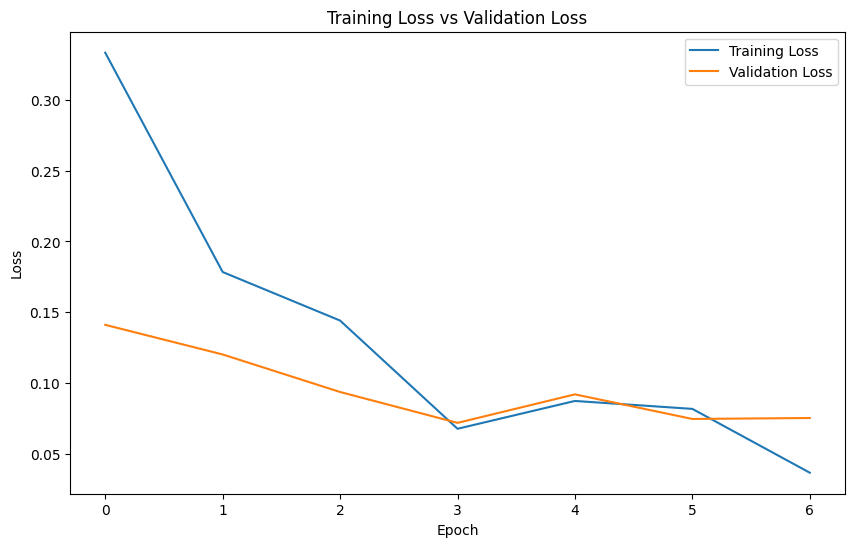

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

relu , tanh , softmax and no drop out

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create pre-trained Xception model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers of the Xception base model
for layer in xception_model.layers:
    layer.trainable = False

# Early stopping callback with adjusted patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Adjusted patience to 5
    restore_best_weights=True
)

# Build a new model on top of Xception
model = Sequential([
    xception_model,
    GlobalAveragePooling2D(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='tanh'),
    Dense(1, activation='softmax')  # Change activation to softmax
])

# Modify the learning rate in the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train_normalized, y_train,
    epochs=50, validation_data=(x_test_normalized, y_test),
    callbacks=[early_stopping]
)

# Print final loss and accuracy
final_loss, final_acc = model.evaluate(x_test_normalized, y_test)
print("Final Loss on Test Data:", final_loss)
print("Accuracy on Test Data:", final_acc)

# Print learning rate
print("Learning Rate:", model.optimizer.learning_rate.numpy())

# Print the number of Dense layers
dense_layer_count = sum([1 for layer in model.layers if isinstance(layer, Dense)])
print("Number of Dense Layers:", dense_layer_count)



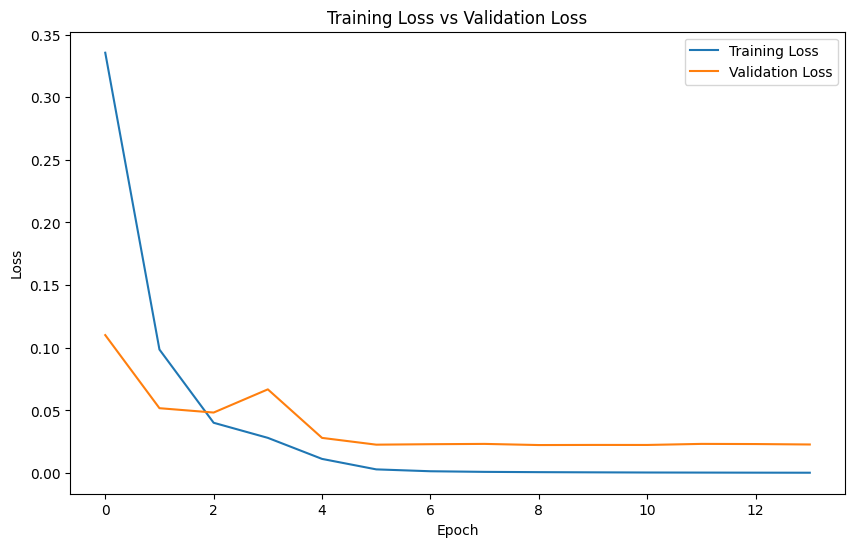

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

all tanh and no dropout and early stopping learning rate 0.001

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create pre-trained Xception model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers of the Xception base model
for layer in xception_model.layers:
    layer.trainable = False

# Build a new model on top of Xception with tanh activation
model = Sequential([
    xception_model,
    GlobalAveragePooling2D(),
    Dense(4096, activation='tanh'),
    Dense(4096, activation='tanh'),
    Dense(1, activation='tanh')  # Change activation to tanh
])

# Modify the learning rate in the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001),  # Change learning rate to 0.001
              loss='binary_crossentropy', metrics=['accuracy'])

# Train the model without early stopping
history = model.fit(
    x_train_normalized, y_train,
    epochs=50, validation_data=(x_test_normalized, y_test)
)

# Print final loss and accuracy
final_loss, final_acc = model.evaluate(x_test_normalized, y_test)
print("Final Loss on Test Data:", final_loss)
print("Accuracy on Test Data:", final_acc)

# Print learning rate
print("Learning Rate:", model.optimizer.learning_rate.numpy())

# Print the number of Dense layers
dense_layer_count = sum([1 for layer in model.layers if isinstance(layer, Dense)])
print("Number of Dense Layers:", dense_layer_count)

# Print summary of the model architecture
model.summary()


Epoch 1/50
75/75 [==============================] - 28s 213ms/step - loss: 7.5862 - accuracy: 0.4963 - val_loss: 7.3705 - val_accuracy: 0.5167
Epoch 2/50
75/75 [==============================] - 12s 156ms/step - loss: 7.6882 - accuracy: 0.4958 - val_loss: 7.3705 - val_accuracy: 0.5167
Epoch 3/50
75/75 [==============================] - 12s 157ms/step - loss: 7.6882 - accuracy: 0.4958 - val_loss: 7.3705 - val_accuracy: 0.5167
Epoch 4/50
75/75 [==============================] - 12s 159ms/step - loss: 7.6882 - accuracy: 0.4958 - val_loss: 7.3705 - val_accuracy: 0.5167
Epoch 5/50
75/75 [==============================] - 12s 164ms/step - loss: 7.6882 - accuracy: 0.4958 - val_loss: 7.3705 - val_accuracy: 0.5167
Epoch 6/50
75/75 [==============================] - 12s 161ms/step - loss: 7.6882 - accuracy: 0.4958 - val_loss: 7.3705 - val_accuracy: 0.5167
Epoch 7/50
75/75 [==============================] - 12s 165ms/step - loss: 7.6882 - accuracy: 0.4958 - val_loss: 7.3705 - val_accuracy: 0.5167

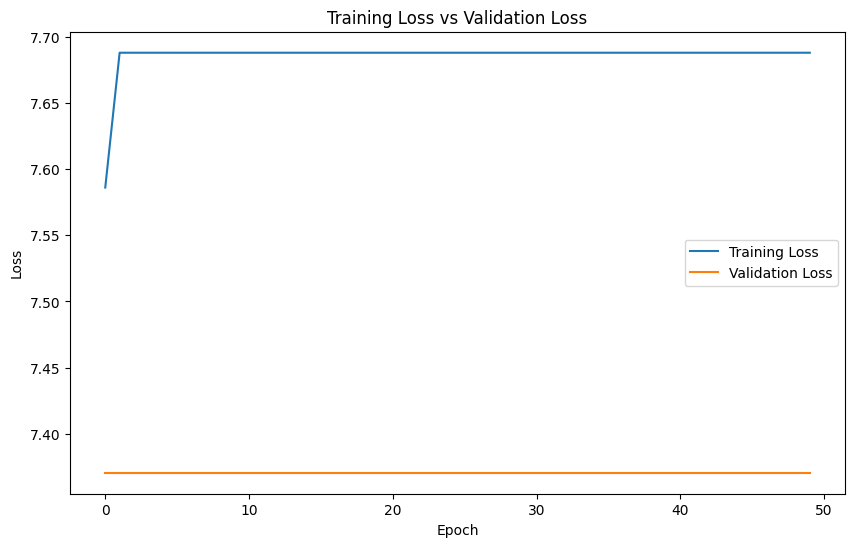

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

relu,leaky relu , softmax

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create pre-trained Xception model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers of the Xception base model
for layer in xception_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

# Build a new model on top of Xception with activations and dropout
model = Sequential([
    xception_model,
    GlobalAveragePooling2D(),
    Dense(4096, activation='relu'),
    Dropout(0.35),  # Add Dropout with a dropout rate of 35%
    Dense(4096, activation='leaky_relu'),  # Change activation to leaky_relu
    Dropout(0.35),  # Add another Dropout layer
    Dense(1, activation='softmax')  # Change activation to softmax
])

# Modify the learning rate in the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train_normalized, y_train,
    epochs=50, validation_data=(x_test_normalized, y_test),
    callbacks=[early_stopping]
)

# Print final loss and accuracy
final_loss, final_acc = model.evaluate(x_test_normalized, y_test)
print("Final Loss on Test Data:", final_loss)
print("Accuracy on Test Data:", final_acc)

# Print learning rate
print("Learning Rate:", model.optimizer.learning_rate.numpy())

# Print the number of Dense layers
dense_layer_count = sum([1 for layer in model.layers if isinstance(layer, Dense)])
print("Number of Dense Layers:", dense_layer_count)



Epoch 1/50
75/75 [==============================] - 28s 229ms/step - loss: 0.7487 - accuracy: 0.4971 - val_loss: 0.2106 - val_accuracy: 0.5117
Epoch 2/50
75/75 [==============================] - 12s 165ms/step - loss: 0.1595 - accuracy: 0.4971 - val_loss: 0.1704 - val_accuracy: 0.5117
Epoch 3/50
75/75 [==============================] - 12s 163ms/step - loss: 0.1124 - accuracy: 0.4971 - val_loss: 0.1966 - val_accuracy: 0.5117
Epoch 4/50
75/75 [==============================] - 13s 168ms/step - loss: 0.1394 - accuracy: 0.4971 - val_loss: 0.1193 - val_accuracy: 0.5117
Epoch 5/50
75/75 [==============================] - 12s 163ms/step - loss: 0.0677 - accuracy: 0.4971 - val_loss: 0.1810 - val_accuracy: 0.5117
Epoch 6/50
75/75 [==============================] - 12s 164ms/step - loss: 0.0820 - accuracy: 0.4971 - val_loss: 0.1774 - val_accuracy: 0.5117
Epoch 7/50
75/75 [==============================] - 13s 169ms/step - loss: 0.0551 - accuracy: 0.4971 - val_loss: 0.1209 - val_accuracy: 0.5117

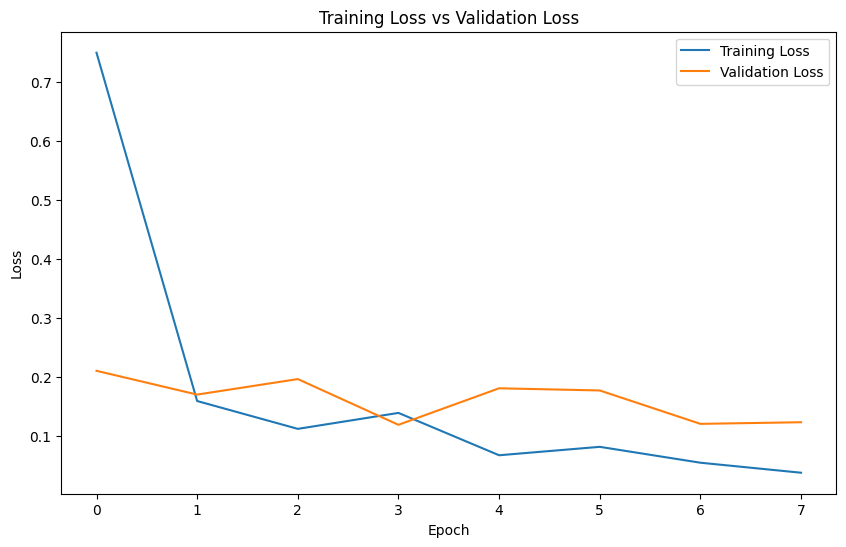

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Leaky relu

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create pre-trained Xception model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers of the Xception base model
for layer in xception_model.layers:
    layer.trainable = False

# Early stopping callback with patience of 5
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Build a new model on top of Xception with Leaky ReLU activations and dropout
model = Sequential([
    xception_model,
    GlobalAveragePooling2D(),
    Dense(4096, activation='leaky_relu'),
    Dropout(0.35),  # Add Dropout with a dropout rate of 35%
    Dense(4096, activation='leaky_relu'),  # Change activation to leaky_relu
    Dropout(0.35),  # Add another Dropout layer
    Dense(1, activation='leaky_relu')  # Change activation to leaky_relu
])

# Modify the learning rate in the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train_normalized, y_train,
    epochs=50, validation_data=(x_test_normalized, y_test),
    callbacks=[early_stopping]
)

# Print final loss and accuracy
final_loss, final_acc = model.evaluate(x_test_normalized, y_test)
print("Final Loss on Test Data:", final_loss)
print("Accuracy on Test Data:", final_acc)

# Print learning rate
print("Learning Rate:", model.optimizer.learning_rate.numpy())

# Print the number of Dense layers
dense_layer_count = sum([1 for layer in model.layers if isinstance(layer, Dense)])
print("Number of Dense Layers:", dense_layer_count)

# Print summary of the model architecture
model.summary()


Epoch 1/50
75/75 [==============================] - 30s 244ms/step - loss: 7.5104 - accuracy: 0.5058 - val_loss: 8.1838 - val_accuracy: 0.4633
Epoch 2/50
75/75 [==============================] - 13s 177ms/step - loss: 7.4848 - accuracy: 0.5092 - val_loss: 8.1838 - val_accuracy: 0.4633
Epoch 3/50
75/75 [==============================] - 14s 181ms/step - loss: 7.4848 - accuracy: 0.5092 - val_loss: 8.1838 - val_accuracy: 0.4633
Epoch 4/50
75/75 [==============================] - 14s 184ms/step - loss: 7.4848 - accuracy: 0.5092 - val_loss: 8.1838 - val_accuracy: 0.4633
Epoch 5/50
75/75 [==============================] - 16s 215ms/step - loss: 7.4848 - accuracy: 0.5092 - val_loss: 8.1838 - val_accuracy: 0.4633
Epoch 6/50
19/19 [==============================] - 3s 134ms/step - loss: 8.1838 - accuracy: 0.4633
Final Loss on Test Data: 8.183757781982422
Accuracy on Test Data: 0.4633333384990692
Learning Rate: 1e-04
Number of Dense Layers: 3
Model: "sequential_2"
_______________________________

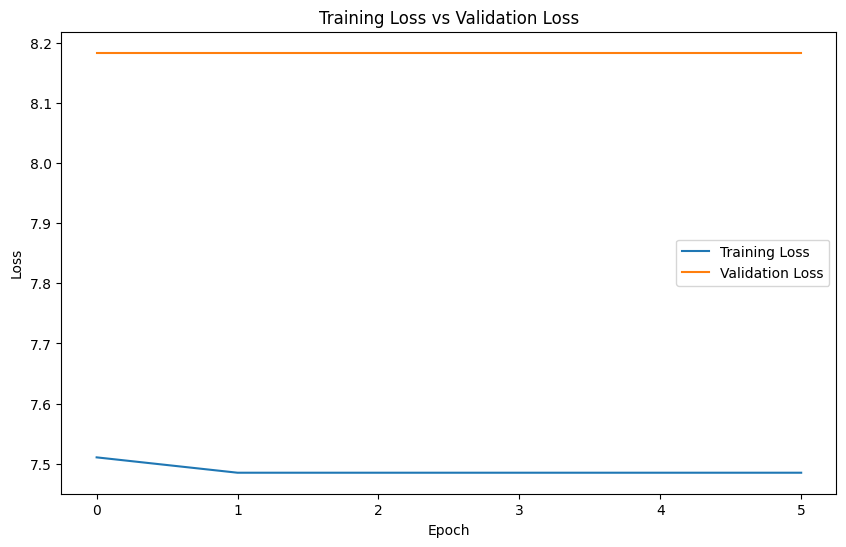

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()